In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import tabulate

In [2]:
# Set plotting style
plt.style.use('seaborn-white')

%matplotlib inline

# Helper functions

In [3]:
def make_markdown_table(df, by, val="total_recurring_comp"):
    frame = df[[by, val]].groupby([by]).agg({val: ["count", "median"]})
    
    print(tabulate.tabulate(frame, tablefmt="pipe", headers="keys"))

In [4]:
def make_plot(df, x, y, file, y_label="", x_label="", order=None):
    # Set plot size
    fig = plt.gcf()
    fig.set_size_inches(12, 8)

    ax = sns.boxplot(
        data=df, 
        x=x, 
        y=y,
        linewidth=2,
        order=order,
    )

    sns.despine(offset=10, trim=True)

    # Use k instead of ,000 for thousands on y-axis
    ax.yaxis.set_major_formatter(ticker.EngFormatter())
    
    plt.ylabel(y_label, fontsize="xx-large")
    plt.xlabel(x_label, fontsize="xx-large")
    plt.tick_params(axis='both', which='major', labelsize=13)

    # Save to disk
    for ext in ("png", "svg"):
        fig.savefig("/tmp/{file}.{ext}".format(file=file, ext=ext), bbox_inches="tight", dpi=300)
        
    return fig

# Data loading and cleaning

The data has already been cleaned in the spreadsheet.

In [5]:
CSV_FILE = "./insight_salary_survey_cleaned.csv"

In [6]:
df = pd.read_csv(
    filepath_or_buffer=CSV_FILE,
    parse_dates=[0],
)

In [7]:
# Fill NaNs in Salary columns with 0s
df = df.fillna({
    "base_salary": 0,
    "annual_bonus": 0,
    "relocation_and_signing": 0,
    "equity_or_stock_per_year": 0,
})

In [8]:
# Add a year column
df["year"] = df["timestamp"].dt.year

In [9]:
# Combine Northeast (Boston) with East Coast (NYC and DC)
# The distributions look identical anyway, and Boston has low N
#
# Also rename "West Coast" to "California" since it's just SF and LA, Seattle is Northwest

df["coarse_region"] = df["coarse_region"].replace({"East Coast": "Northeast", "West Coast": "California"})

In [10]:
# Add a Base + Bonus column
df["base_and_bonus"] = df["base_salary"] + df["annual_bonus"]

In [11]:
df.head(3)

,timestamp,base_salary,annual_bonus,relocation_and_signing,equity_or_stock_per_year,total_comp,total_recurring_comp,job_title,seniority,years_exp,degree,approx_location,coarse_region,fine_region,gender,ethnicity,age_range,age,year,base_and_bonus
0,2017-04-21 15:23:00,115000,8000.0,7500.0,59500.0,190000,182500,Data Scientist,Junior/entry level,0,Doctorate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,123000.0
1,2017-04-21 15:27:00,137800,16000.0,28000.0,0.0,181800,153800,Machine Learning Engineer,Middle,1,Doctorate,South Bay,California,Bay Area,NaN,NaN,NaN,NaN,2017,153800.0
2,2017-04-21 15:28:00,125000,16000.0,5000.0,15000.0,161000,156000,Data Scientist,Junior/entry level,1,Doctorate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,141000.0


# Salary by job title

In [12]:
df_tmp = df[df["job_title"] != "Product Manager"]
df_tmp = df_tmp[df_tmp["job_title"] != "Software Engineer"]

In [13]:
make_markdown_table(df_tmp, "job_title")

| job_title                 |   ('total_recurring_comp', 'count') |   ('total_recurring_comp', 'median') |
|:--------------------------|------------------------------------:|-------------------------------------:|
| Analyst                   |                                   5 |                               105002 |
| Data Engineer             |                                  14 |                               128000 |
| Data Scientist            |                                 132 |                               145000 |
| Machine Learning Engineer |                                   8 |                               161900 |


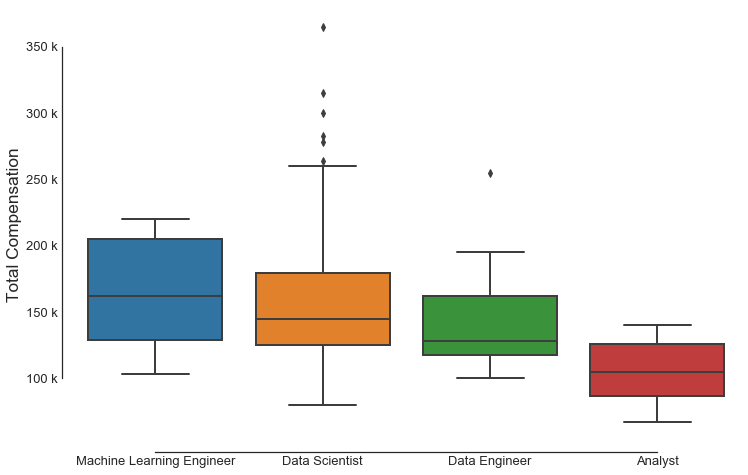

In [14]:
order = df_tmp.groupby(["job_title"])["total_recurring_comp"].median().sort_values(ascending=False).index.values
  
fig = make_plot(
    df=df_tmp,
    x="job_title",
    y="total_recurring_comp",
    file="data_science_total_comp_vs_others",
    y_label="Total Compensation",
    order=order,
)

# Salary by job title and location

In [15]:
df_tmp = df[df["job_title"] == "Data Scientist"]
df_tmp = df_tmp[df_tmp["coarse_region"].isin(["California", "Northeast", "Northwest", "Midwest"])]

In [16]:
make_markdown_table(df_tmp, "coarse_region")

| coarse_region   |   ('total_recurring_comp', 'count') |   ('total_recurring_comp', 'median') |
|:----------------|------------------------------------:|-------------------------------------:|
| California      |                                  54 |                               170000 |
| Midwest         |                                   5 |                               124000 |
| Northeast       |                                  57 |                               137000 |
| Northwest       |                                   6 |                               133750 |


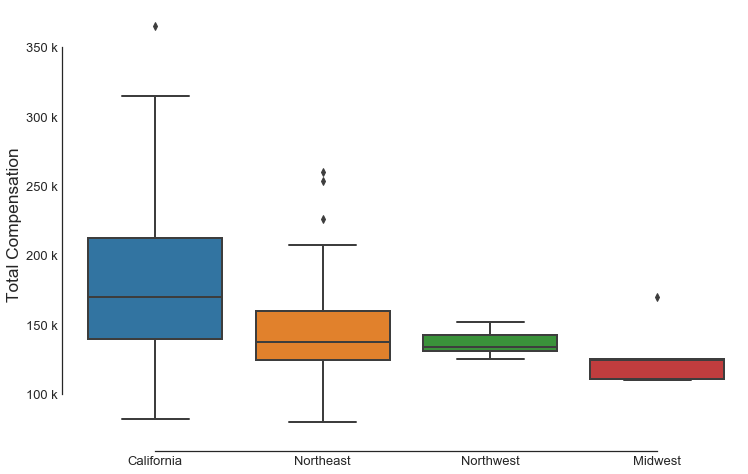

In [17]:
order = df_tmp.groupby(["coarse_region"])["total_recurring_comp"].median().sort_values(ascending=False).index.values

fig = make_plot(
    df=df_tmp,
    x="coarse_region",
    y="total_recurring_comp",
    file="data_science_total_comp_by_region",
    y_label="Total Compensation",
    order=order,
)

In [18]:
make_markdown_table(df_tmp, "coarse_region", "base_and_bonus")

| coarse_region   |   ('base_and_bonus', 'count') |   ('base_and_bonus', 'median') |
|:----------------|------------------------------:|-------------------------------:|
| California      |                            54 |                         150750 |
| Midwest         |                             5 |                         124000 |
| Northeast       |                            57 |                         137000 |
| Northwest       |                             6 |                         128500 |


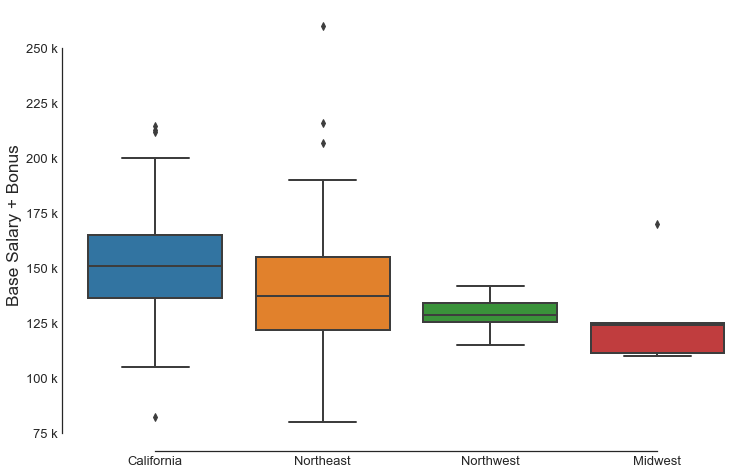

In [19]:
fig = make_plot(
    df=df_tmp,
    x="coarse_region",
    y="base_and_bonus",
    file="data_science_salary_by_region",
    y_label="Base Salary + Bonus",
    order=order,
)

In [20]:
df_tmp[df_tmp["base_salary"] <= 85000]

,timestamp,base_salary,annual_bonus,relocation_and_signing,equity_or_stock_per_year,total_comp,total_recurring_comp,job_title,seniority,years_exp,degree,approx_location,coarse_region,fine_region,gender,ethnicity,age_range,age,year,base_and_bonus
21,2017-04-22 13:08:00,80000,2000.0,0.0,0.0,82000,82000,Data Scientist,Junior/entry level,1,Doctorate,CA,California,NaN,NaN,NaN,NaN,NaN,2017,82000.0
26,2017-04-23 05:48:00,80000,0.0,0.0,0.0,80000,80000,Data Scientist,Junior/entry level,1,Doctorate,New York,Northeast,New York,NaN,NaN,NaN,NaN,2017,80000.0


# Change in salary by experience

In [21]:
df_tmp = df[df["job_title"] == "Data Scientist"]
df_tmp = df_tmp[df_tmp["coarse_region"] == "California"]

In [22]:
make_markdown_table(df_tmp, "years_exp")

|   years_exp |   ('total_recurring_comp', 'count') |   ('total_recurring_comp', 'median') |
|------------:|------------------------------------:|-------------------------------------:|
|           0 |                                   6 |                               125000 |
|           1 |                                  20 |                               166688 |
|           2 |                                  17 |                               193000 |
|           3 |                                   7 |                               264000 |
|           4 |                                   4 |                               159000 |


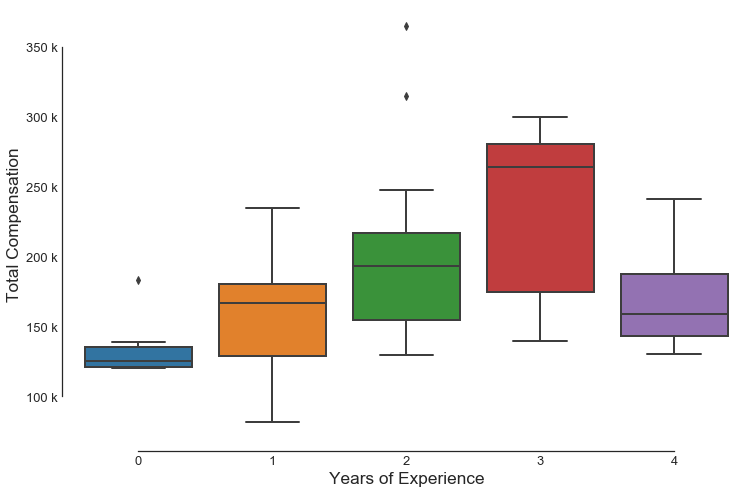

In [23]:
fig = make_plot(
    df=df_tmp,
    x="years_exp",
    y="total_recurring_comp",
    file="data_science_total_comp_by_experience",
    y_label="Total Compensation",
    x_label="Years of Experience"
)

# Change in salary by level

In [24]:
df_tmp = df[df["job_title"] == "Data Scientist"]
df_tmp = df_tmp[df_tmp["coarse_region"] == "California"]

In [25]:
make_markdown_table(df_tmp, "seniority")

| seniority          |   ('total_recurring_comp', 'count') |   ('total_recurring_comp', 'median') |
|:-------------------|------------------------------------:|-------------------------------------:|
| Junior/entry level |                                  17 |                               130000 |
| Middle             |                                  24 |                               181750 |
| Senior             |                                  13 |                               205000 |


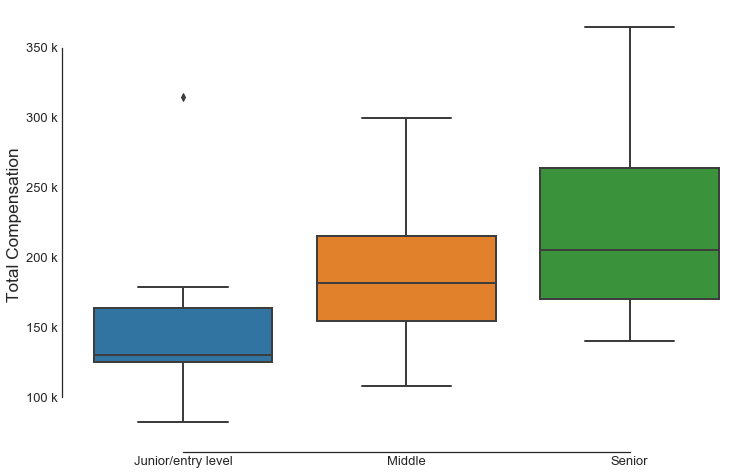

In [26]:
fig = make_plot(
    df=df_tmp,
    x="seniority",
    y="total_recurring_comp",
    file="data_science_total_comp_by_seniority",
    y_label="Total Compensation",
    order=["Junior/entry level", "Middle", "Senior"]
)